# Pipeline to Detect Lanes
---

## Calibrate Camera

This step needs to only be done once.

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle

%matplotlib qt
# %matplotlib inline

## Parameters

These include:
- Checkerboard dimensions
- Input file directory with images

In [2]:
checkcols = 9
checkrows = 6
imdir = 'camera_cal/'

## Get Points to Run Calibration

In [3]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((checkcols*checkrows,3), np.float32)
objp[:,:2] = np.mgrid[0:checkcols, 0:checkrows].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images. Each element in this list is
# the image name has (9,6) number of corners
images = [imdir+'calibration'+str(i)+'.jpg' for i in range(2,21)]

# Test calibration images 
test_calibration = ['camera_cal/calibration1.jpg', 'camera_cal/calibration20.jpg']

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (checkcols,checkrows), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        print("Image: {} calibration successful".format(fname))

        # Draw and display the corners
        '''
        cv2.drawChessboardCorners(img, (checkcols,checkrows), corners, ret)
        write_name = 'corners_found'+str(idx)+'.jpg'
        cv2.imwrite(write_name, img)
        cv2.imshow('img', img)
        cv2.waitKey(500)
        '''
    
    else:
        print("Calibration Unsuccessful for {}".format(fname))
        
cv2.destroyAllWindows()

Image: camera_cal/calibration2.jpg calibration successful
Image: camera_cal/calibration3.jpg calibration successful
Calibration Unsuccessful for camera_cal/calibration4.jpg
Calibration Unsuccessful for camera_cal/calibration5.jpg
Image: camera_cal/calibration6.jpg calibration successful
Image: camera_cal/calibration7.jpg calibration successful
Image: camera_cal/calibration8.jpg calibration successful
Image: camera_cal/calibration9.jpg calibration successful
Image: camera_cal/calibration10.jpg calibration successful
Image: camera_cal/calibration11.jpg calibration successful
Image: camera_cal/calibration12.jpg calibration successful
Image: camera_cal/calibration13.jpg calibration successful
Image: camera_cal/calibration14.jpg calibration successful
Image: camera_cal/calibration15.jpg calibration successful
Image: camera_cal/calibration16.jpg calibration successful
Image: camera_cal/calibration17.jpg calibration successful
Image: camera_cal/calibration18.jpg calibration successful
Image: 

## Find Parameters to Undistort

Length Objects: 17, Image Points: 17
Image Size: (1280, 720)


Text(0.5,1,'Undistorted Image')

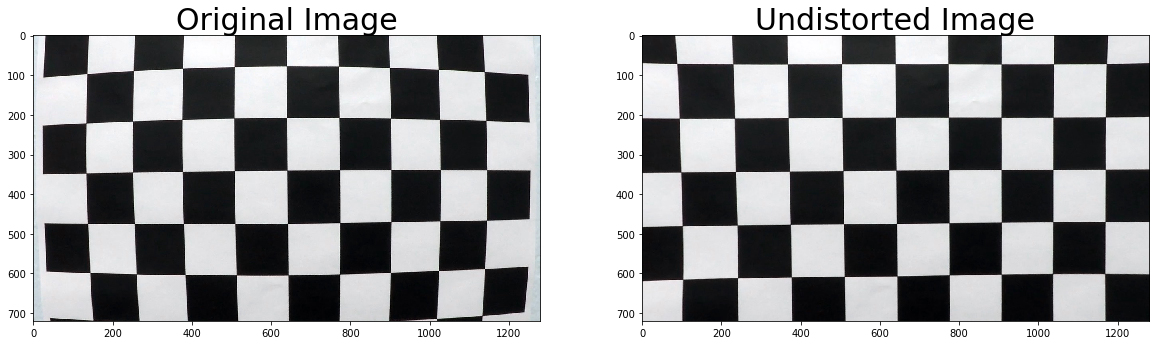

In [4]:
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
print('Length Objects: {}, Image Points: {}'.format(len(objpoints), len(imgpoints)))
print('Image Size: {}'.format(img_size))
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
dst = cv2.undistort(img, mtx, dist, None, mtx)

'''
# No need to perform the below. We don't need to save our parameters

# cv2.imwrite('camera_cal/test_image.jpg',dst)
# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "dist_pickle.p", "wb" ) )
dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
'''

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

## Reprojection Parameters (Perspective)

Text(0.5,1,'Warped Image')

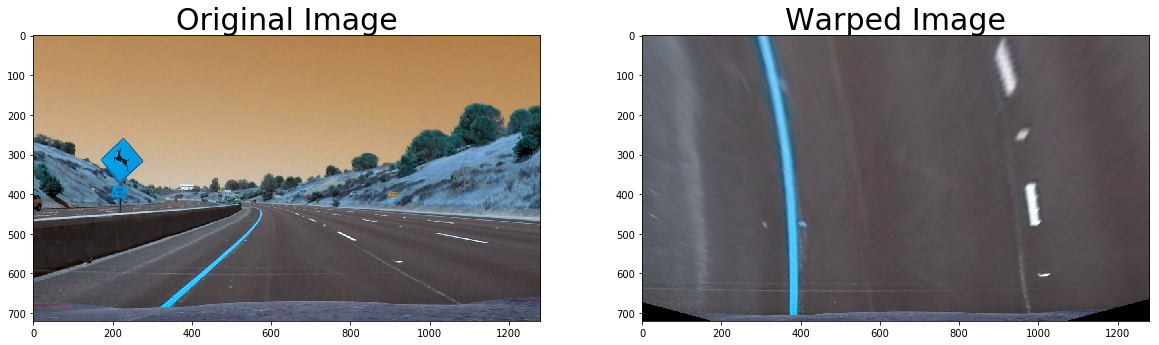

In [27]:
# Original Parameters
src = np.float32(
     [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
     [((img_size[0] / 6) - 10), img_size[1]],
     [(img_size[0] * 5 / 6) + 60, img_size[1]],
     [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
dst = np.float32(
    [[(img_size[0] / 4), 0],
     [(img_size[0] / 4), img_size[1]],
     [(img_size[0] * 3 / 4), img_size[1]],
     [(img_size[0] * 3 / 4), 0]])

# Format is:
#    [ UpperLeft, LowerLeft, LowerRight, UpperRight ]
src = np.float32(
     [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
     [((img_size[0] / 6) - 10), img_size[1]],
     [(img_size[0] * 5 / 6) + 60, img_size[1]],
     [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
dst = np.float32(
    [[(img_size[0] / 4)+50, 0],
     [(img_size[0] / 4), img_size[1]],
     [(img_size[0] * 3 / 4), img_size[1]],
     [(img_size[0] * 3 / 4)-50, 0]])

# Format is:
#   [ LowerLeft, LowerRight, UpperLeft, UpperRight]
# src = np.float32([[256,682],[1038,675],[607,444],[672,453]])
# dst = np.float32([[img_size[0]/4,img_size[1]],
#                   [img_size[0]*3/4,img_size[1]],
#                   [img_size[0]/4, 100],
#                   [img_size[0]*3/4, 100]])

# img = cv2.imread('test_images/test3.jpg')
img = cv2.imread('test_images/test2.jpg')
M = cv2.getPerspectiveTransform(src, dst)
warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(warped)
ax2.set_title('Warped Image', fontsize=30)